# As TestingAndDevelopment.ipynb, but for small numbers and poisson-process assumptions

In [740]:
import numpy as np 
import pandas as pd

import ExcessMortalityFunctions as emf
from importlib import reload
reload(emf)

from scipy.stats import poisson

import matplotlib.pyplot as plt

%matplotlib widget

# import sys
 
# # setting path
# sys.path.append('../Functions')
# import PandemiXSignaturesForSubfolders as ps


# Generate data to use

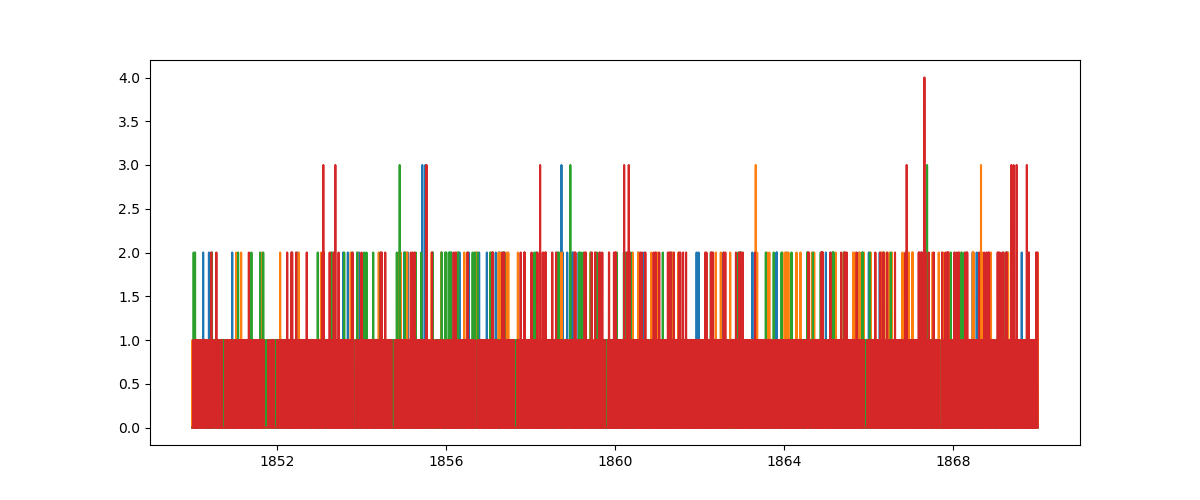

In [741]:
# Generate some data for testing
d1 = np.datetime64('1850-01-01')
d2 = np.datetime64('1870-01-01')
ts = np.arange(d1,d2)

# Constant
# curMean = 1
curMean = 0.1
# curMean = 40
curBase = poisson.rvs(curMean,size = len(ts))
curBaseConstant = curMean * np.ones(len(ts))

# Linearly increasing
# curMean2 = 4
curMean2 = curMean * 2
allMeans = np.linspace(curMean,curMean2,len(ts))
curBase2 = poisson.rvs(allMeans,size = len(ts))

# Sinusoidal
tDays = (ts -ts[0])/np.timedelta64(1,'D')
# sinAmp = 2
sinAmp = curMean/2
sinPer = 2*np.pi/365.25
curSin = sinAmp * np.sin(tDays * sinPer) + sinAmp + curMean 
curBase3 = poisson.rvs(curSin,size = len(ts))


# Sinusoidal and linear
tDays = (ts -ts[0])/np.timedelta64(1,'D')
curSin = sinAmp * np.sin(tDays * sinPer) + sinAmp + allMeans
curBase4 = poisson.rvs(curSin,size = len(ts))

# Plot
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(ts,curBase)
ax.plot(ts,curBase2)
ax.plot(ts,curBase3)
ax.plot(ts,curBase4)


In [742]:

df = pd.DataFrame(
    index = ts,
    data={
        'Constant':curBaseConstant,
        'Base':curBase,
        'Base2':curBase2,
        'Base3':curBase3,
        'Base4':curBase4,
        }
)

In [743]:
def reshapePivot(pivotTable):
        
    pivotTable = pivotTable.reset_index().melt(id_vars='Year') # Melt pivottable
    pivotTable['Date'] = pd.to_datetime(dict(year=pivotTable.Year,month=pivotTable.Month,day=pivotTable.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
    pivotTable = pivotTable.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
    pivotTable = pivotTable.loc[pivotTable.index.notna()] # Remove invalid dates (leap-days in not leap-years)

    return pivotTable

def reshapePivotMonth(pivotTable):
    pivotTable = pivotTable.reset_index().melt(id_vars='Year')
    pivotTable['Date'] = pd.to_datetime(dict(year=pivotTable.Year,month=pivotTable.Month,day=np.ones(len(pivotTable.Year))))
    pivotTable = pivotTable.sort_values('Date').set_index('Date').drop(columns=['Year','Month']).rename(columns={'value':'Baseline'}).iloc[:,0]

    return pivotTable

# Small variance test 

In [744]:
pd.set_option('display.min_rows', 20)

In [745]:
from scipy.stats import norm 

testVals = norm.rvs(10,0.5,size=100)



In [746]:
# for numSamples in range(1,10):
#     curVals = testVals[:numSamples]
#     testMean = np.mean(curVals)

#     print(np.sum(np.power(curVals - testMean,2))/numSamples)
#     print(np.sum(np.power(curVals - testMean,2))/(numSamples-1))
#     print(numSamples,f'{testMean:0.2f}',np.std(curVals)**2)

In [747]:
testSer = pd.Series(testVals)

testStd0 = testSer.rolling(window=21,center=True,min_periods=12).std(ddof=0)
testStd1 = testSer.rolling(window=21,center=True,min_periods=12).std(ddof=1)
testMean = testSer.rolling(window=21,center=True,min_periods=12).mean()

In [748]:
# testMean

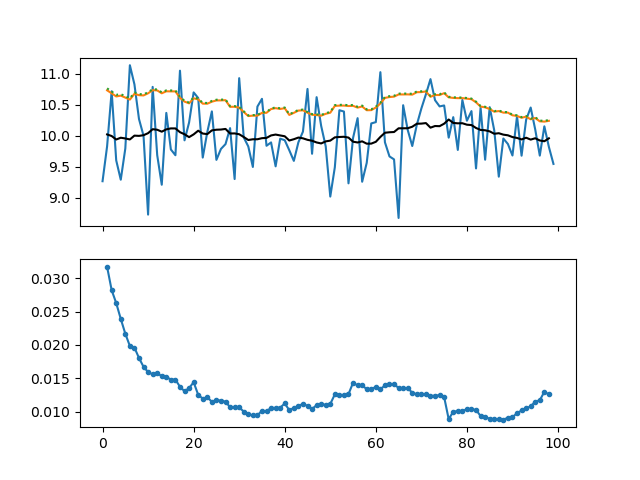

In [749]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True)
ax.plot(testSer)
ax.plot(testMean,'k')
ax.plot(testMean+testStd0)
ax.plot(testMean+testStd1,':')
# ax2.plot(testStd0)
# ax2.plot(testStd1,':')
ax2.plot(testStd1-testStd0,'.-')
# ax.hist(testVals)

# Monthly

In [750]:
reload(emf)

<module 'ExcessMortalityFunctions' from 'c:\\NonSyncedFiles\\GithubRepos\\ExcessMortality\\ExcessMortalityFunctions.py'>

In [751]:
numYears = 5
# numYears = 12
# numYears = 24
# curData = df.Constant
curData = df.Base

curData = emf.groupByMonth(curData)

In [752]:

curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Month')
# # curMean,curStd = emf.rnMean(curData,numYears=numYears,timeResolution='Day')

In [753]:

# Start by grouping data by month, in case it's on daily resolution
serMonth = curData.groupby([curData.index.year.rename('Year'),curData.index.month.rename('Month')]).sum(min_count=1)

# Organize as pivot table
curPivot = serMonth.to_frame().pivot_table(serMonth.name,index='Year',columns='Month')

# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum()
curCount = curRolling.count()
# curSum = curPivot.rolling(window=(numYears*2)+1,center=True).sum()

# Calculate mean of surrounding years by subtracting the current year and dividing by the number of surrounding years
# curMean = (curSum - curPivot)/(numYears*2)
curMean = (curSum - curPivot.fillna(0))/(curCount-curPivot.notna()*1)

# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum() # Get sum of all values in roll
curCount = curRolling.count() # Count how many values were used in sum (to avoid counting NaN's)

curMean = (curSum - curPivot.fillna(0))/(curCount-curPivot.notna()*1)
curMean

curSF = pd.DataFrame(poisson.logsf(curPivot,curMean),columns=curPivot.columns,index=curPivot.index)



# Calculate the sum of squares of surrounding years and current year
curSumSqr = curPivot.pow(2).rolling(window=(numYears*2)+1,center=True,min_periods=1).sum()
# curMeanSqr = (curSumSqr - curPivot.pow(2))/(numYears*2)
curMeanSqr = (curSumSqr - curPivot.pow(2).fillna(0))/(curCount-curPivot.notna()*1)

# Calculate emperical standard deviation 
curStd = (curMeanSqr - curMean.pow(2))
curStd = curStd / (curCount.pow(0.5))
curStd = curStd.pow(0.5)


# curStd

# curStd = curStd* ((curCount-1)/(curCount))
curStd 

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1850,1.533463,0.866705,0.808206,0.939051,0.651597,1.099279,0.939051,1.185063,0.255577,0.745129,0.651597,1.099279
1851,1.613616,1.263270,0.844945,1.359348,0.422473,1.159256,0.679674,1.145590,0.289814,0.844945,0.709896,1.103579
1852,1.348434,1.177010,0.778519,1.177010,0.997859,1.047252,0.700461,1.026375,0.433128,0.832272,0.588505,0.945889
1853,1.305038,1.077710,0.572822,1.134221,1.058202,0.957427,0.813301,0.912871,1.288976,0.703414,0.535218,0.803638
1854,1.138483,0.909757,0.838289,1.007498,1.019057,0.795271,0.918300,0.530180,1.271328,0.800165,0.558859,1.030486
1855,1.041845,0.944708,0.784272,0.951070,1.013979,0.736696,0.793825,0.976102,1.177689,0.744836,0.351596,0.887099
1856,1.025804,0.857722,0.738739,0.768741,0.988381,0.754888,0.852433,0.976102,1.214245,0.623658,0.551839,1.130667
1857,1.172558,1.054788,0.918821,1.043291,0.738739,0.892183,0.807010,0.995978,1.177689,0.694563,0.746857,1.146555
1858,1.126660,1.025804,0.918821,1.071801,0.952654,0.859478,0.912234,1.110487,0.551839,0.866466,0.821818,0.976102


In [754]:
# (curCount-1)/(curCount)
# np.sqrt(curCount)
# curCount

In [755]:

# curBot1,curTop1 = poisson.interval(0.5,curMean)
# curBot2,curTop2 = poisson.interval(0.75,curMean)
# curBot3,curTop3 = poisson.interval(0.95,curMean)

# curBot1 = pd.DataFrame(curBot1,columns=curPivot.columns,index=curPivot.index)
# curBot2 = pd.DataFrame(curBot2,columns=curPivot.columns,index=curPivot.index)
# curBot3 = pd.DataFrame(curBot3,columns=curPivot.columns,index=curPivot.index)
# curTop1 = pd.DataFrame(curTop1,columns=curPivot.columns,index=curPivot.index)
# curTop2 = pd.DataFrame(curTop2,columns=curPivot.columns,index=curPivot.index)
# curTop3 = pd.DataFrame(curTop3,columns=curPivot.columns,index=curPivot.index)
# # poisson.ppf(0.75,curMean[1][1])
# # curMean[1][1]


In [756]:
# curSF = emf.reshapePivot(curSF)

In [757]:
# curSF.rename('SF')

In [759]:
curSF = emf.reshapePivot(curSF,timeResolution='Month')
curMean = emf.reshapePivot(curMean,timeResolution='Month')

curStd = emf.reshapePivot(curStd,timeResolution='Month')

curBot1,curTop1 = emf.getPoissonIntervals(0.5,curMean)
curBot2,curTop2 = emf.getPoissonIntervals(0.75,curMean)
curBot3,curTop3 = emf.getPoissonIntervals(0.95,curMean)

 
# curBot1 = emf.reshapePivot(curBot1,timeResolution='Month')
# curBot2 = emf.reshapePivot(curBot2,timeResolution='Month')
# curBot3 = emf.reshapePivot(curBot3,timeResolution='Month')
# curTop1 = emf.reshapePivot(curTop1,timeResolution='Month')
# curTop2 = emf.reshapePivot(curTop2,timeResolution='Month')
# curTop3 = emf.reshapePivot(curTop3,timeResolution='Month')

In [760]:
# # poisson.interval(0.95,curMean)

# curMean
# curBot1,curTop1 = poisson.interval(0.5,curMean)

# # curBot1 = pd.DataFrame(curBot1,columns=curPivot.columns,index=curPivot.index)
# pd.Series(curBot1,index=curMean.index)

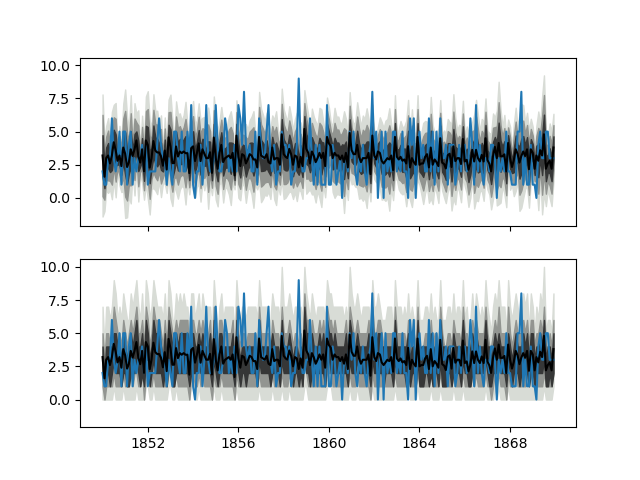

In [761]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,sharey=True)
ax1.plot(curData)
ax1.plot(curMean,color='k') 

ax1.fill_between(curData.index,curMean-3*curStd,curMean+3*curStd,color='xkcd:light grey')
ax1.fill_between(curData.index,curMean-2*curStd,curMean+2*curStd,color='xkcd:grey')
ax1.fill_between(curData.index,curMean-curStd,curMean+curStd,color='xkcd:dark grey')


ax2.plot(curData)
ax2.plot(curMean,color='k') 

ax2.fill_between(curData.index,curBot3,curTop3,color='xkcd:light grey')
ax2.fill_between(curData.index,curBot2,curTop2,color='xkcd:grey')
ax2.fill_between(curData.index,curBot1,curTop1,color='xkcd:dark grey')
# ax2.fill_between(curData.index,curMean-2*curStd,curMean+2*curStd,color='xkcd:grey')
# ax2.fill_between(curData.index,curMean-curStd,curMean+curStd,color='xkcd:dark grey')


# Some basic tests

In [380]:
# Add some random high values
dfOut = df.copy()

len(dfOut)
# indexToIncrease = np.random.randint(0,len(dfOut),100)
indexToIncrease = np.random.randint(0,len(dfOut),50)

# dfOut.iloc[indexToIncrease,:] = dfOut.iloc[indexToIncrease,:]*8
dfOut.iloc[indexToIncrease,:] = dfOut.iloc[indexToIncrease,:] + 15
# dfOut.iloc[indexToIncrease,:] = 20
# dfOut.iloc[indexToIncrease]

In [381]:
# dfOut

In [382]:
numYears = 5
# curData = dfOut.Constant
# curData = df.Base4
# curData = dfOut.Base3
# curData = dfOut.Base2
curData = dfOut.Base4
# curData = dfOut.Constant

In [383]:
# curDataRaw = curData.copy()
# curData = curData.rolling(window=7,center=True).mean()

In [384]:

# Add columns for year, month and day
curFrame = curData.to_frame()
curFrame['Year'] = curFrame.index.year 
curFrame['Month'] = curFrame.index.month
curFrame['Day'] = curFrame.index.day

# Organize as pivot-table (with multi-columns)
curPivot = curFrame.pivot_table(values=curData.name,columns=['Month','Day'],index='Year')

# curPivot.head()

In [385]:

# Calculate sum of surrounding years and current year
curRolling = curPivot.rolling(window=(numYears*2)+1,center=True,min_periods=1)
curSum = curRolling.sum() # Get sum of all values in roll
curCount = curRolling.count() # Count how many values were used in sum (to avoid counting NaN's)

curMean = (curSum - curPivot.fillna(0))/(curCount-curPivot.notna()*1)
curMean

curSF = pd.DataFrame(poisson.logsf(curPivot,curMean),columns=curPivot.columns,index=curPivot.index)
# curMean.shape

# curPivot.apply()
# curPivot
# curSF





In [421]:
# curMean[2][6:]


In [387]:

curBot1,curTop1 = poisson.interval(0.5,curMean)
curBot2,curTop2 = poisson.interval(0.75,curMean)
curBot3,curTop3 = poisson.interval(0.95,curMean)

curBot1 = pd.DataFrame(curBot1,columns=curPivot.columns,index=curPivot.index)
curBot2 = pd.DataFrame(curBot2,columns=curPivot.columns,index=curPivot.index)
curBot3 = pd.DataFrame(curBot3,columns=curPivot.columns,index=curPivot.index)
curTop1 = pd.DataFrame(curTop1,columns=curPivot.columns,index=curPivot.index)
curTop2 = pd.DataFrame(curTop2,columns=curPivot.columns,index=curPivot.index)
curTop3 = pd.DataFrame(curTop3,columns=curPivot.columns,index=curPivot.index)
# poisson.ppf(0.75,curMean[1][1])
# curMean[1][1]


In [389]:

# Reshape pivottables into series
curMean = curMean.reset_index().melt(id_vars='Year') # Melt pivottable
curMean['Date'] = pd.to_datetime(dict(year=curMean.Year,month=curMean.Month,day=curMean.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curMean = curMean.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'Baseline'}).iloc[:,0] # Sort by date and drop extra columns
curMean = curMean.loc[curMean.index.notna()] # Remove invalid dates (leap-days in not leap-years)

curSF = curSF.reset_index().melt(id_vars='Year') # Melt pivottable
curSF['Date'] = pd.to_datetime(dict(year=curSF.Year,month=curSF.Month,day=curSF.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
curSF = curSF.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
curSF = curSF.loc[curSF.index.notna()] # Remove invalid dates (leap-days in not leap-years)

# curBot1 = curBot1.reset_index().melt(id_vars='Year') # Melt pivottable
# curBot1['Date'] = pd.to_datetime(dict(year=curBot1.Year,month=curBot1.Month,day=curBot1.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
# curBot1 = curBot1.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
# curBot1 = curBot1.loc[curBot1.index.notna()] # Remove invalid dates (leap-days in not leap-years)

# curTop1 = curTop1.reset_index().melt(id_vars='Year') # Melt pivottable
# curTop1['Date'] = pd.to_datetime(dict(year=curTop1.Year,month=curTop1.Month,day=curTop1.Day),errors='coerce') # Make a date-columns (coerce "false" leap-days to NaT, i.e. in non-leap years)
# curTop1 = curTop1.sort_values('Date').set_index('Date').drop(columns=['Year','Month','Day']).rename(columns={'value':'StandardDeviation'}).iloc[:,0] # Sort by date and drop extra columns
# curTop1 = curTop1.loc[curTop1.index.notna()] # Remove invalid dates (leap-days in not leap-years)

 
curBot1 = reshapePivot(curBot1)
curBot2 = reshapePivot(curBot2)
curBot3 = reshapePivot(curBot3)
curTop1 = reshapePivot(curTop1)
curTop2 = reshapePivot(curTop2)
curTop3 = reshapePivot(curTop3)

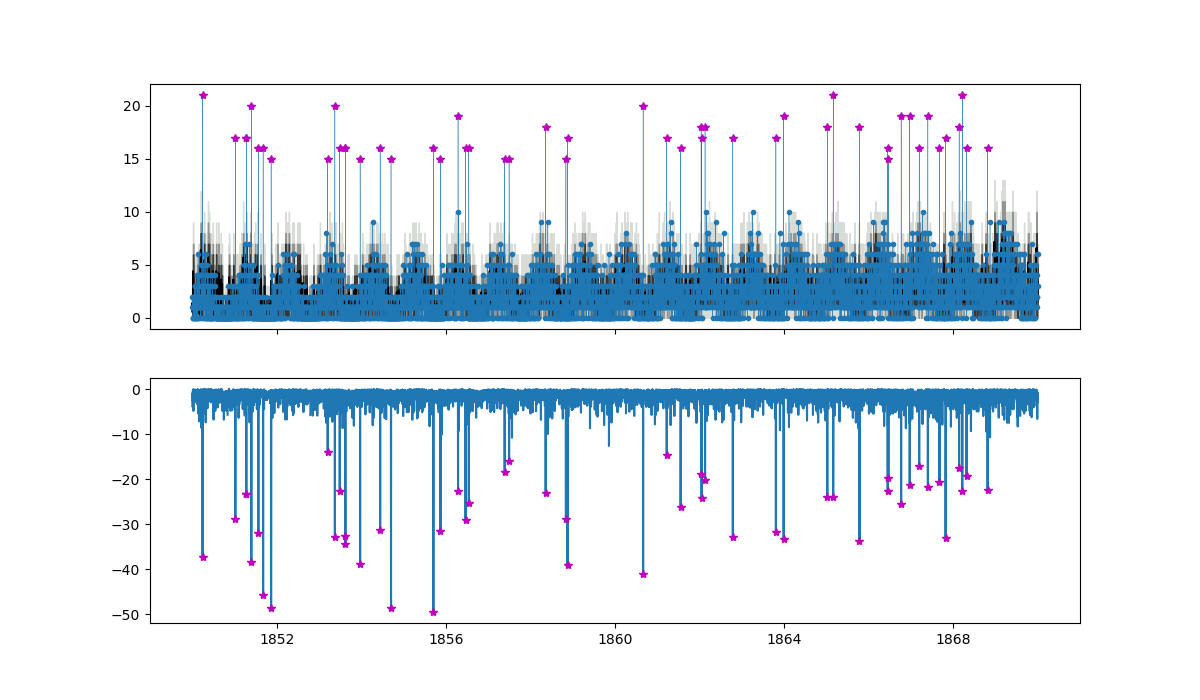

In [390]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,7))

ax.plot(curMean,'k')
ax.plot(curData,'.-',lw=0.3)
ax.plot(curData.iloc[indexToIncrease] ,'*m',lw=0.3)

ax.fill_between(curMean.index,curBot3,curTop3,color='xkcd:light gray')
ax.fill_between(curMean.index,curBot2,curTop2,color='xkcd:gray')
ax.fill_between(curMean.index,curBot1,curTop1,color='xkcd:dark gray')

# ax.plot(curMean.index,allMeans,lw=5)
 
ax2.plot(curSF)
ax2.plot(curSF.iloc[indexToIncrease] ,'*m')

In [187]:
# fig,(ax,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,7))

# ax.plot(curMean.iloc[::7])
# ax.plot(curData.iloc[::7],'.-',lw=0.3)
# ax.plot(curDataRaw.iloc[indexToIncrease]/7 ,'*m',lw=0.3)

# # ax.plot(curMean.index,allMeans,lw=5)

# ax2.plot(curSF.iloc[::7])
# # ax2.plot(curSF.iloc[indexToIncrease] ,'*m')